<h3 align="right">MSN D2</h3>

# Single-cell simulation

## Model data

In [1]:
import cell_model, cell_evaluator
morphofile = 'morphology/WT-P270-09-14ak.swc'
parameters = cell_model.define_parameters('parameters.json')
mechanisms = cell_model.define_mechanisms('mechanisms.json')
protocols = cell_evaluator.define_protocols('protocols.json')
calculator = cell_evaluator.define_fitness_calculator(protocols, 'features.json')
expdata = {
    'IV_529.soma.v': 'expdata/ECBL_IV_ch3_529.dat',
    'IV_535.soma.v': 'expdata/ECBL_IV_ch3_535.dat',
    'IV_540.soma.v': 'expdata/ECBL_IV_ch3_540.dat',
    'IDthresh_602.soma.v': 'expdata/ECBL_IDthresh_ch3_602.dat',
    'IDthresh_608.soma.v': 'expdata/ECBL_IDthresh_ch3_608.dat'
}

## Simulation environment

In [2]:
!nrnivmodl mechanisms

/home/akozlov/prog/optim/bgopt/cells/msn_d2_all-5-20170517
mechanisms/bk.mod mechanisms/cadyn.mod mechanisms/cal12.mod mechanisms/cal13.mod mechanisms/caldyn.mod mechanisms/can.mod mechanisms/caq.mod mechanisms/car.mod mechanisms/cat32.mod mechanisms/cat33.mod mechanisms/kaf.mod mechanisms/kas.mod mechanisms/kdr.mod mechanisms/kdrf.mod mechanisms/kdrs.mod mechanisms/kir.mod mechanisms/kir21.mod mechanisms/kir23.mod mechanisms/kirin.mod mechanisms/kmf.mod mechanisms/kms.mod mechanisms/naf.mod mechanisms/nap.mod mechanisms/sk.mod
bk.mod cadyn.mod cal12.mod cal13.mod caldyn.mod can.mod caq.mod car.mod cat32.mod cat33.mod kaf.mod kas.mod kdr.mod kdrf.mod kdrs.mod kir.mod kir21.mod kir23.mod kirin.mod kmf.mod kms.mod naf.mod nap.mod sk.mod
"/usr/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/include/nrn" -I"/usr/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/include/nrn -I/usr/lib -g -O2 -c mod_func.

In [3]:
import numpy as np
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def plot_responses(responses, expdata=None, junction_potential=0):
    fig, axes = plt.subplots(len(responses), figsize=(8,12))
    for index, (name, response) in enumerate(sorted(responses.items())):
        if name in expdata:
            data = np.loadtxt(expdata[name])
            time = data[:,0]
            voltage = data[:,1] - junction_potential
            axes[index].plot(time, voltage, color='lightgrey', linewidth=3)
        axes[index].plot(response['time'], response['voltage'])
        axes[index].set_title(name)
    fig.tight_layout()

## Cell model definition

In [6]:
morphology = ephys.morphologies.NrnFileMorphology(
    morphofile, do_replace_axon=True)

In [7]:
cell = ephys.models.CellModel(
    'msn_d2', 
    morph=morphology, 
    mechs=mechanisms, 
    params=parameters)
print cell

msn_d2:
  morphology:
    morphology/WT-P270-09-14ak.swc
  mechanisms:
    naf.basal: naf at ['basal']
    kaf.basal: kaf at ['basal']
    kas.basal: kas at ['basal']
    kdrf.basal: kdrf at ['basal']
    kir23.basal: kir23 at ['basal']
    cal12.basal: cal12 at ['basal']
    cal13.basal: cal13 at ['basal']
    car.basal: car at ['basal']
    cat32.basal: cat32 at ['basal']
    cat33.basal: cat33 at ['basal']
    cadyn.basal: cadyn at ['basal']
    caldyn.basal: caldyn at ['basal']
    sk.basal: sk at ['basal']
    bk.basal: bk at ['basal']
    pas.all: pas at ['all']
    naf.axonal: naf at ['axonal']
    nap.axonal: nap at ['axonal']
    kas.axonal: kas at ['axonal']
    kdrs.axonal: kdrs at ['axonal']
    kmf.axonal: kmf at ['axonal']
    naf.somatic: naf at ['somatic']
    kaf.somatic: kaf at ['somatic']
    kas.somatic: kas at ['somatic']
    kdrf.somatic: kdrf at ['somatic']
    kir23.somatic: kir23 at ['somatic']
    cal12.somatic: cal12 at ['somatic']
    cal13.somatic: cal13 at

In [8]:
opt_params = [p.name for p in cell.params.values() if not p.frozen]
for x in sorted(opt_params): print x

e_pas.all
g_pas.axonal
g_pas.basal
g_pas.somatic
gbar_bk.basal
gbar_bk.somatic
gbar_kaf.basal
gbar_kaf.somatic
gbar_kas.axonal
gbar_kas.basal
gbar_kas.somatic
gbar_kdrf.basal
gbar_kdrf.somatic
gbar_kdrs.axonal
gbar_kir23.basal
gbar_kir23.somatic
gbar_kmf.axonal
gbar_naf.axonal
gbar_naf.basal
gbar_naf.somatic
gbar_nap.axonal
gbar_sk.basal
gbar_sk.somatic


## Cell evaluator

In [9]:
simulator = ephys.simulators.NrnSimulator()

In [10]:
evaluator = ephys.evaluators.CellEvaluator(
    cell_model=cell,
    param_names=opt_params,
    fitness_protocols=protocols,
    fitness_calculator=calculator,
    sim=simulator)

## Experimental protocol

In [11]:
import json
hall_of_fame = json.load(open('hall_of_fame.json'))
import pandas
pandas.options.display.float_format = '{:,.5g}'.format
pandas.DataFrame(hall_of_fame).T

0          1          2          3          4  \
e_pas.all             -64.659    -60.171    -65.698     -64.71    -60.618   
g_pas.axonal        0.0044029  0.0041813  0.0045569  0.0043087  0.0043346   
g_pas.basal        8.7438e-05 9.1103e-05 7.3145e-05 1.2267e-05 9.8803e-06   
g_pas.somatic      0.00040723 0.00012081 0.00013479 0.00020454 0.00023268   
gbar_bk.basal      2.0127e-05 8.5077e-05  0.0001006 4.9048e-05 0.00055916   
gbar_bk.somatic    0.00088926 0.00094445 0.00092645 0.00090074 0.00029819   
gbar_kaf.basal     5.1825e-05   0.001154 5.1838e-07 0.00087287 0.00057022   
gbar_kaf.somatic     0.041425   0.012124   0.043364   0.004379   0.012532   
gbar_kas.axonal      0.066998   0.043701    0.06697   0.049101   0.093583   
gbar_kas.basal      0.0004536 0.00017454 0.00014968 0.00087037  0.0028839   
gbar_kas.somatic    0.0032461  0.0061751  0.0032461 0.00048641    0.11458   
gbar_kdrf.basal     0.0044569  0.0028881  0.0041639   0.005648 0.00014924   
gbar_kdrf.somatic   0.0013038  0.0023402 0.00086231   0.005384  0.0091312   
gbar_kdrs.axonal     0.086252   0.085449   0.090739    0.09676   0.051902   
gbar_kir23.basal   8.3296e-05 0.00036518 8.3206e-05 0.00017844 1.7013e-05   
gbar_kir23.somatic  0.0065986   0.000703  0.0065981  0.0025535   0.005115   
gbar_kmf.axonal    0.00099505 0.00060013 0.00074482 0.00093811  0.0007176   
gbar_naf.axonal        0.3444     1.0288    0.23748    0.17269    0.36395   
gbar_naf.basal      0.0034013   0.016809  0.0034013  0.0031933  0.0044748   
gbar_naf.somatic       9.6501     11.257      18.87     12.824     13.857   
gbar_nap.axonal    5.1841e-05 5.8064e-05  4.188e-05 0.00024356 0.00030275   
gbar_sk.basal       0.0092604  0.0090719   0.008428  0.0092604  0.0090358   
gbar_sk.somatic     0.0070454  0.0052229   0.008851   0.005311  0.0030324   

                            5          6          7          8          9  
e_pas.all             -60.417     -60.57    -64.468    -62.388    -60.294  
g_pas.axonal        0.0048421  0.0047976  0.0039857  0.0036434  0.0048103  
g_pas.basal        9.6923e-06  9.966e-06  1.034e-05 0.00061443 0.00043552  
g_pas.somatic      9.2687e-05 0.00025432    0.00011 0.00014849 0.00044062  
gbar_bk.basal      0.00031648 0.00018983 0.00035196  0.0005546  0.0006255  
gbar_bk.somatic     0.0004591 0.00095512 0.00039441 0.00066919 0.00027398  
gbar_kaf.basal     9.6336e-05 2.5729e-05 0.00018509   0.004679   0.017535  
gbar_kaf.somatic     0.029715    0.16681  0.0010324    0.24289    0.32382  
gbar_kas.axonal      0.043698    0.06846   0.057593  0.0015121   0.070658  
gbar_kas.basal      0.0082688  0.0003818 0.00028543  0.0016562   0.011394  
gbar_kas.somatic     0.043806   0.055682   0.017196   0.039035   0.097609  
gbar_kdrf.basal     0.0077531  0.0025923  0.0056011  0.0035455   0.007966  
gbar_kdrf.somatic   0.0042625  0.0038586  0.0079951  0.0032049  0.0089834  
gbar_kdrs.axonal     0.090353   0.056109   0.072217   0.081719   0.030478  
gbar_kir23.basal   0.00016141 0.00012603 9.7934e-05 0.00011586 0.00029928  
gbar_kir23.somatic 0.00046294  0.0012185  0.0046452   0.003593  0.0076645  
gbar_kmf.axonal    0.00092022  0.0006058 0.00081349 0.00079528 1.6474e-05  
gbar_naf.axonal         3.256     4.0841    0.22925      2.578     19.658  
gbar_naf.basal       0.001742   0.084727   0.007053   0.094922   0.035138  
gbar_naf.somatic        12.09     9.4677      9.057     19.062      3.031  
gbar_nap.axonal    0.00062335 0.00035498 7.2533e-05 0.00050437 0.00041898  
gbar_sk.basal       0.0063374  0.0079533  0.0031719   0.003829  0.0091576  
gbar_sk.somatic      0.005061  0.0099228  0.0067101  0.0049655  0.0098151

In [12]:
#par = [p['gbar_kir23.somatic'] for p in hall_of_fame]
#print np.mean(par), np.std(par), np.median(par)
#plt.hist(par)

In [13]:
test_parameters = hall_of_fame[0]
#test_parameters['gbar_kas.basal']=0

In [14]:
test_responses = evaluator.run_protocols(
    protocols=protocols.values(), 
    param_values=test_parameters)

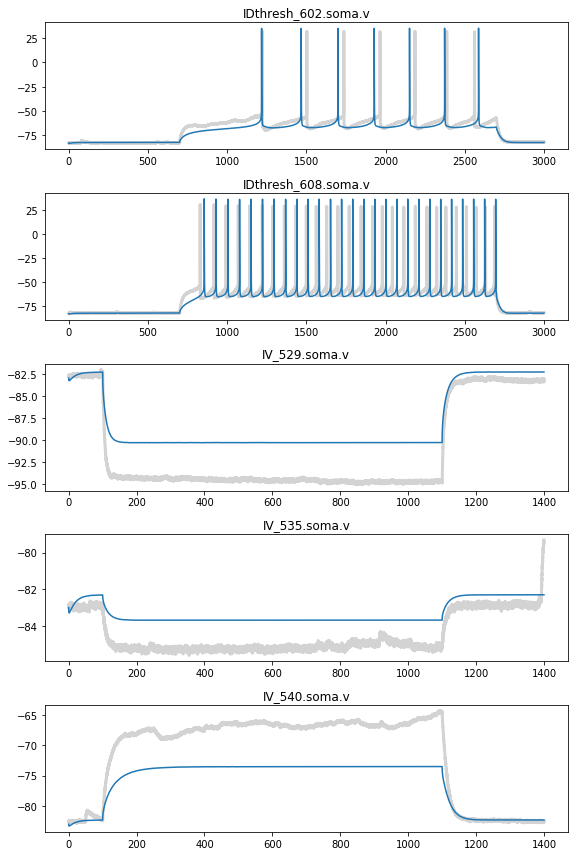

In [15]:
plot_responses(test_responses, expdata=expdata, junction_potential=9.5)

In [16]:
import efel
traces = []
names = []
for i in [529, 535, 540]:
    name = 'IV_%d.soma.v' % i
    response = test_responses[name]
    trace = {}
    trace['T'] = response['time']
    trace['V'] = response['voltage']
    trace['stim_start'] = [100]
    trace['stim_end'] = [1100]
    traces.append(trace)
    names.append(name)

import json
f=json.load(open('config/features.json'))
features = f['IV_529'].values()[0].keys()

results = efel.getFeatureValues(traces, features)
import pandas
pandas.DataFrame(results, index=names).T

IV_529.soma.v      IV_535.soma.v  \
Spikecount                                   [0]                [0]   
decay_time_constant_after_stim   [13.4445215343]    [15.2295028692]   
voltage_base                    [-82.3171398575]   [-82.3171398575]   
voltage_deflection              [-7.44456893473]  [-0.816022342317]   

                                   IV_540.soma.v  
Spikecount                                   [0]  
decay_time_constant_after_stim   [22.0833691754]  
voltage_base                    [-82.3171398575]  
voltage_deflection               [9.36130692044]

In [17]:
import efel
traces = []
names = []
for i in [602, 608]:
    name = 'IDthresh_%d.soma.v' % i
    response = test_responses[name]
    trace = {}
    trace['T'] = response['time']
    trace['V'] = response['voltage']
    trace['stim_start'] = [700]
    trace['stim_end'] = [2700]
    traces.append(trace)
    names.append(name)

import json
f=json.load(open('config/features.json'))
features = f['IDthresh_602'].values()[0].keys()
features.append('inv_first_ISI')
#features.append('AHP_time_from_peak')
#features.append('AHP_slow_time')
#features.append('AP_begin_voltage')

results = efel.getFeatureValues(traces, features)
import pandas
pandas.DataFrame(results, index=names).T

IDthresh_602.soma.v  \
AHP1_depth_from_peak                                        [101.039445546]   
AHP2_depth_from_peak                                        [100.021513578]   
AP1_amp                                                     [84.8307136219]   
AP1_width                                                  [0.669300526755]   
AP2_amp                                                      [83.587154688]   
AP2_width                                                  [0.758857903571]   
AP_begin_voltage          [-49.8599631097, -49.3010514142, -48.985084995...   
ISI_CV                                                     [0.031226694618]   
Spikecount                                                              [7]   
adaptation_index2                                        [-0.0100316159144]   
inv_first_ISI                                               [4.00480576692]   
mean_frequency                                              [3.70939536856]   
steady_state_voltage                                       [-81.0554733929]   
time_to_first_spike                                                 [517.8]   
voltage_base                                               [-82.3024836086]   
voltage_deflection_begin                                    [12.7948059981]   

                                                        IDthresh_608.soma.v  
AHP1_depth_from_peak                                        [101.927259633]  
AHP2_depth_from_peak                                        [101.290848952]  
AP1_amp                                                     [86.2621919497]  
AP1_width                                                  [0.720924306789]  
AP2_amp                                                     [86.1322657216]  
AP2_width                                                   [0.64605117642]  
AP_begin_voltage          [-49.5385360284, -50.0333888801, -49.520052654...  
ISI_CV                                                    [0.0244700858271]  
Spikecount                                                             [27]  
adaptation_index2                                       [-0.00158221281535]  
inv_first_ISI                                               [13.5317997294]  
mean_frequency                                              [13.5317997294]  
steady_state_voltage                                       [-81.1410868435]  
time_to_first_spike                                                 [155.6]  
voltage_base                                               [-82.3024836086]  
voltage_deflection_begin                                    [19.9852463754]

In [18]:
import json
with open('best_parameters.json', 'w') as fp:
    json.dump(test_parameters, fp, indent=4, sort_keys=True)